In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys

import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
figure_save_path = Path(parent_dir) / 'figures'
if not figure_save_path.exists():
    os.makedirs(figure_save_path)

import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from models.ICL import MultiResolutionPDF
import sys
import torch
sys.path.append("../models")

In [2]:
### load all series
processed_series_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)
  
all_series = {}
processed_series = {}
for idx, file in enumerate(generated_series_files):
    series_name = file.name.rsplit('_', 1)[0]
    if series_name not in all_series:
        all_series[series_name] = []
        processed_series[series_name] = []
    series_dict = pickle.load(file.open('rb'))
    series_dict['series_name'] = file.name[:-4]
    corresponding_processed_file = next((processed_file for processed_file in processed_series_files if processed_file.name == file.name), None)
    if corresponding_processed_file is not None:
        processed_dict = pickle.load(corresponding_processed_file.open('rb'))
        series_dict['processed?'] = "yes" 
        processed_series[series_name] += [processed_dict]
    else:
        series_dict['processed?'] = 'no'
    all_series[series_name] += [series_dict]
    

# Create a DataFrame to store the series data
series_df = pd.DataFrame(columns=['Name', 'Random Seed', 'Precision', 'Mode', 'refine_depth', '# states', 'llama_size', 'processed?'])

for key, series_list in all_series.items():
    if key == 'markov_chain':
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': ["NA"], 
                                    'Mode': ["NA"],
                                    'refine_depth': ["NA"],
                                    '# states': [series['P'].shape[0]],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)
    else:
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': [series['prec']], 
                                    'Mode': [series['mode']],
                                    'refine_depth': [series['refine_depth']],
                                    '# states': ['NA'],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)

# Print the DataFrame without the index
print(series_df.to_string(index=False))


                        Name Random Seed Precision     Mode refine_depth # states llama_size processed?
           brownian_motion_0           5         3 neighbor            2       NA        13b        yes
           brownian_motion_1           6         3 neighbor            2       NA        13b        yes
          brownian_motion_10          13         3 neighbor            2       NA        13b        yes
          brownian_motion_11          14         3 neighbor            2       NA        13b        yes
          brownian_motion_12           7         2      all            1       NA        13b        yes
          brownian_motion_13           8         2      all            1       NA        13b        yes
          brownian_motion_14           9         2      all            1       NA        13b        yes
          brownian_motion_15          10         2      all            1       NA        13b        yes
          brownian_motion_16          11         2      all     

In [4]:
### Load Multi-PDF
### Color Multi-PDF by binwidth
### Load and plot observed states
experiment_dict = processed_series['noisy_logistic_map'][0]
PDF_list = experiment_dict['PDF_list']
full_series = experiment_dict['full_series']
state_idx = 829
import copy
PDF = copy.deepcopy(PDF_list[state_idx])
w = 0.1
coarse_bin_center = np.linspace(4, 5, 10, endpoint = False) + w/2
coarse_bin_width = np.ones(10) * w
PDF.coarsen(coarse_bin_center, coarse_bin_width)

coarse_bin_center = np.linspace(6, 7, 10, endpoint = False) + w/2
coarse_bin_width = np.ones(10) * w
PDF.coarsen(coarse_bin_center, coarse_bin_width)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


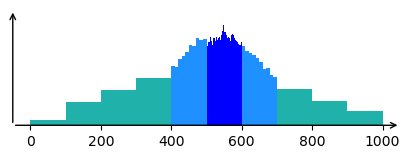

In [37]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(1, 1, figsize=(5, 1.5))
PDF.plot(ax=axs, statistic = False)
axs.set_yscale('log')

# Define a function to multiply the x values by 1000
def multiply_by_1000(x, pos):
    return '%1.0f' % (x * 100)

# Create a formatter
formatter = FuncFormatter(multiply_by_1000)

# Set the formatter
axs.xaxis.set_major_formatter(formatter)

# Hide the right and top spines
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
# Remove y-axis ticks
axs.set_yticks([])
# Only show ticks on the left and bottom spines
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')

# Add arrows at the end of each axis
axs.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(0, 0), 
             arrowprops=dict(arrowstyle="->", color='k'))
axs.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 0), 
             arrowprops=dict(arrowstyle="->", color='k'))
axs.get_legend().remove()
plt.show()

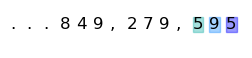

In [33]:
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
string_idx = comma_locations[state_idx]
fig3_string = '...' + full_series[string_idx-11: string_idx]
fig, ax = plt.subplots(figsize=(3, 0.5))
# Define colors
colors = ['lightseagreen', 'dodgerblue', 'blue']

# Plot each character
for i, char in enumerate(fig3_string):
    # Choose color for the last three characters
    if i >= len(fig3_string) - 3:
        color = colors[i - (len(fig3_string) - 3)]
        ax.text(i, 0, char, color='black', fontsize=12, 
                 bbox=dict(facecolor=color, alpha=0.4, edgecolor=color, boxstyle='square,pad=0'))  # Add a shaded box
    else:
        color = 'black'
        ax.text(i, 0, char, color=color, fontsize=12)

# Set the plot limits
ax.set_xlim([0, len(fig3_string)])  # Set x limits to the length of the string
ax.set_ylim([-1, 1])  # Set y limits to -1 and 1

# Remove axes for clarity
ax.axis('off')

plt.show()

In [7]:
### Logistic Map

from scipy.stats import norm
x_values = np.linspace(0, 1, 100)

r = 3.9
sigma = 0.03
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

gaussian_dist_list = []
i_arr = np.linspace(0,1,10, endpoint=False)+0.05

print(i_arr)

for x in i_arr:
    j_mean = logistic_map(r, x)
    j_sigma = logistic_map_diff(r, x) * sigma
    gaussian = norm.pdf(x_values, j_mean, j_sigma)
    gaussian_dist_list += [gaussian]

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


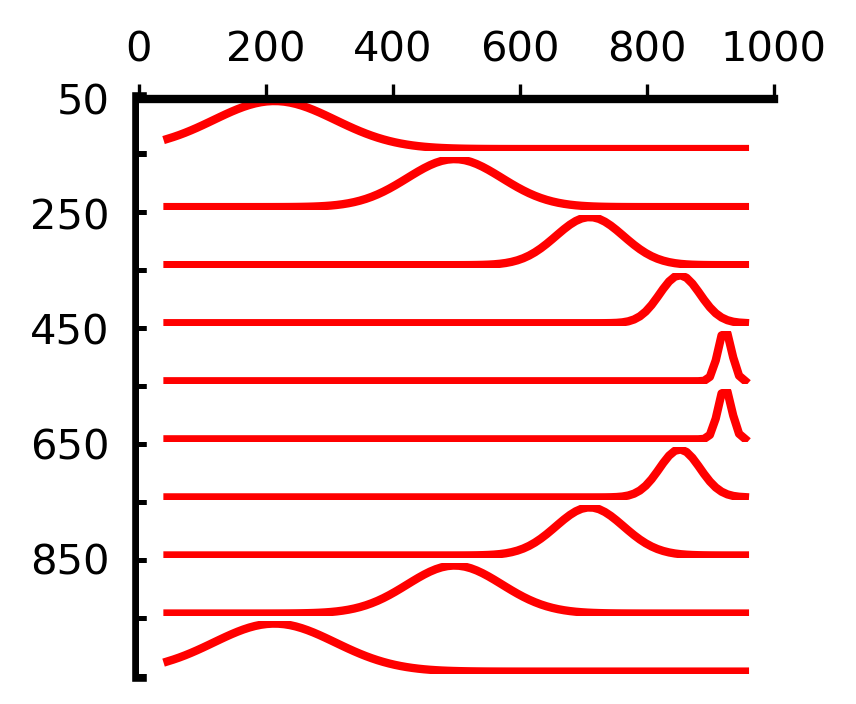

In [65]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(3, 2.5), dpi=300)
fig.patch.set_facecolor('none')  # Set the background color to transparent


# Create a new subplot for the y-axis that spans all rows
ax_y = fig.add_subplot(111)
ax_y.spines['left'].set_linewidth(3.5)  # Make the y-axis thicker
ax_y.spines['right'].set_visible(False)
ax_y.spines['top'].set_visible(False)
ax_y.spines['bottom'].set_visible(False)
ax_y.yaxis.set_ticks_position('left')
ax_y.yaxis.set_tick_params(direction='out')
ax_y.set_xticks([])

# Set the y-axis labels from 0 to 1000 from top to bottom
ax_y.set_ylim([1000, 0])
ax_y.set_yticks(np.linspace(0, 1000, 5, endpoint = False))  # Change the number of ticks as needed

# Get current y-tick labels
y_tick_labels = ax_y.get_yticklabels()

# Convert labels to integers, add 50, and convert back to string
new_y_tick_labels = [str(int(label.get_text()) + 50) for label in y_tick_labels]

# Set new y-tick labels
ax_y.set_yticklabels(new_y_tick_labels)

ax_y.yaxis.set_ticks_position('none')
# Create the subplots for the plots
axs = [fig.add_subplot(len(gaussian_dist_list), 1, i+1, sharex=ax_y) for i in range(len(gaussian_dist_list))]

# Create a twin axis for the first subplot (x-axis)
ax2 = axs[0].twiny()

for i, dist in enumerate(gaussian_dist_list):
    axs[i].plot(x_values, dist, c = 'red', lw = 2)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    for spine in ['left', 'right', 'top', 'bottom']:
        axs[i].spines[spine].set_visible(False)


# Define a function to multiply the x values by 1000
def multiply_by_1000(x, pos):
    return '%1.0f' % (x * 1000 )

# Create a formatter
formatter = FuncFormatter(multiply_by_1000)

# Set the formatter
ax2.xaxis.set_major_formatter(formatter)

# Set the visibility of the spines and ticks for the twin axes
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.xaxis.set_ticks_position('top')  # set the position of the x-axis ticks
ax2.xaxis.set_tick_params(direction='out')  # set the direction of the x-axis ticks

ax3.spines['left'].set_visible(True)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.yaxis.set_ticks_position('left')  # set the position of the y-axis ticks
ax3.yaxis.set_tick_params(direction='out')  # set the direction of the y-axis ticks

# Thicken both axes
ax2.spines['top'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)

plt.tight_layout()  # adjust the layout so labels don't overlap
plt.subplots_adjust(hspace=0.1)  # decrease the vertical space between subplots
# plt.savefig(figure_save_path / "Pij_logistic.png")


plt.show()

In [154]:
### Load Multi-PDF
### Color Multi-PDF by binwidth
### Load and plot observed states
experiment_dict = processed_series['markov_chain'][10]
state_idx = 802
P = experiment_dict['P']
full_array = experiment_dict['full_array']
full_series = experiment_dict['full_series']
state = full_array[state_idx-1]
true_dist = P[state]
n = P.shape[0]  # au
print(f"sahpe of transition matrix is {n} x {n}")
print(f'preceding state is {state}')


sahpe of transition matrix is 6 x 6
preceding state is 2


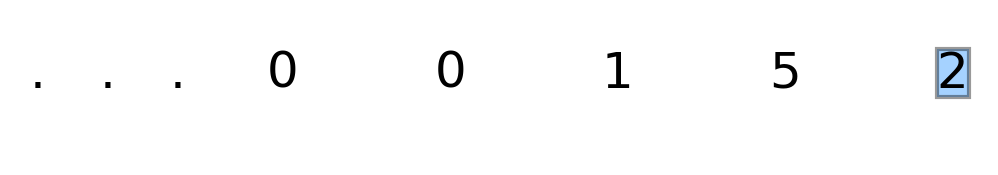

In [155]:
fig2_string = full_series[state_idx-5: state_idx]
fig, ax = plt.subplots(figsize=(3, 0.5), dpi=300)
# Define colors

# Plot each character
for i in range(3):
    ax.text(i*0.5, 0, '.', color=color, fontsize=12)
for i, char in enumerate(fig2_string):
    # Choose color for the last three characters
    if i == len(fig2_string)-1:
        ax.text(1.7+i*1.2, 0, char, color='black', fontsize=12, 
                 bbox=dict(facecolor='dodgerblue', alpha=0.4, edgecolor=color, boxstyle='square,pad=0'))  # Add a shaded box
    else:
        color = 'black'
        ax.text(1.7+i*1.2, 0, char, color=color, fontsize=12)

# Set the plot limits
ax.set_xlim([0, len(fig2_string)])  # Set x limits to the length of the string
ax.set_ylim([-1, 1])  # Set y limits to -1 and 1

# Remove axes for clarity
ax.axis('off')

plt.show()

TypeError: subplots_adjust() got an unexpected keyword argument 'vspace'

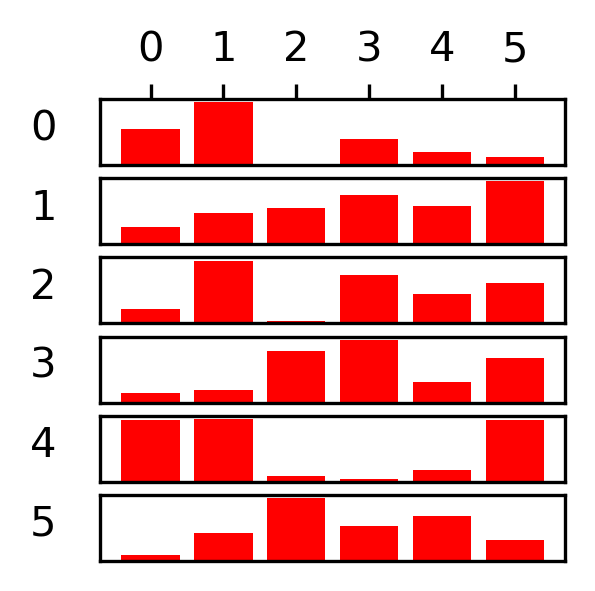

In [132]:
fig = plt.figure(figsize=(2,2), dpi=300)
n = P.shape[0]  # automatically extract matrix size n
for i in range(n):
    ax = plt.subplot(n, 1, i+1)
    plt.bar(range(n), P[i, :], color='red')
    ax.yaxis.set_visible(False)  # turn off y-axis labels
    # plt.box(False)  # turn off the frame
    ax.set_xticks(range(n))  # set x-axis labels from 0 to n
    if i != 0:  # if not the last subplot
        ax.xaxis.set_visible(False)  # turn off x-axis labels
    else:  # if it is the last subplot
        ax.xaxis.tick_top()  # move x-axis ticks to the top
        ax.xaxis.set_visible(True) 
    fig.text(0.03, (n-i+0.3)/(n+1.6), str(i), va='center', ha='center', rotation='horizontal')  # label each subplot

plt.subplots_adjust(vspace=0)  # decrease the vertical space between subplots
plt.tight_layout()

[]

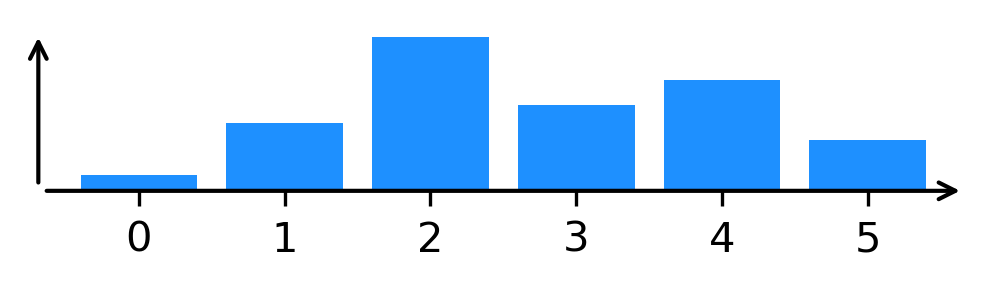

In [153]:
fig, axs = plt.subplots(1, 1, figsize=(4, 0.7), dpi=300)
plt.bar(range(n), true_dist, color='dodgerblue')
axs.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(0, 0), 
             arrowprops=dict(arrowstyle="->", color='k'))
axs.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 0), 
             arrowprops=dict(arrowstyle="->", color='k'))

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.yaxis.set_ticks([])  # turn off y ticks